In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

In [2]:
from glob import glob 
import os
from tqdm import tqdm_notebook as tqdm 


import numpy as np
import scipy.ndimage


import sys
sys.path.append('../scripts')
import load_utils
import watereshed
import generator_3D

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
PATHS = {
    'DATA': '/home/ubuntu/cdata/DM_Data/RIII',
    'DESC': '/home/ubuntu/cdata/DM_Data/REPRISEIIISizes.xlsx'
}

In [4]:
def slice_along(arr, ids, axis):
    arr = np.swapaxes(arr, axis, 0)
    arr = arr[slice(*ids)]
    return np.swapaxes(arr, axis, 0)

In [5]:
def support(el):
    i, patient_id, mes, pat = el
    pat, marker = watereshed.watereshed(pat)
    patch = np.dstack([pat, mes[:pat.shape[0], :pat.shape[1]]])
    np.save(os.path.join(PATHS['DATA'], 'watereshed', patient_id, 'patch_' + str(i)), patch)
    np.save(os.path.join(PATHS['DATA'], 'watereshed', patient_id, 'marker_' + str(i)), marker)

In [6]:
def process(patient_id):    
    patient, meta = load_utils.load_patient(PATHS['DATA'], patient_id, metadata=True)

    meshs = glob(os.path.join(PATHS['DATA'], patient_id, '*_A.stl'))
    meshs = load_utils.load_mesh(meshs[0], meta) 

    bbox = np.array(np.where(meshs))
    bbox = np.array([bbox.min(1), bbox.max(1)])
    bbox_shape = np.diff(bbox, axis=0).astype(np.int).flatten()
    bbox_centroid = bbox.mean(0).astype(np.int)

    bbox_axes = [0] 
    for bb_axis in bbox_axes:
        bb_ids = (
            bbox_centroid[bb_axis] - bbox_shape[bb_axis] // 2, 
            bbox_centroid[bb_axis] + bbox_shape[bb_axis] // 2
        )
        bb_ids = np.clip(bb_ids, 0, patient.shape[bb_axis])
        meshs = slice_along(meshs, bb_ids, bb_axis)
        patient = slice_along(patient, bb_ids, bb_axis)

    try:
        os.mkdir(os.path.join(PATHS['DATA'], 'watereshed', patient_id))
    except:
        pass
    
    with Pool(14) as pool:
        pool.map(support, list(zip(np.arange(len(meshs)), [patient_id] * len(meshs), meshs, patient)))
    
    meta['patient_id'] = patient_id
    meta['shape'] = patient.shape
    
    return meta

In [7]:
try:
    os.mkdir(os.path.join(PATHS['DATA'], 'watereshed'))
except:
    pass

In [ ]:
import pickle

processeds = pickle.load(open(os.path.join(PATHS['DATA'], 'watereshed_processed_meta.pkl'), 'rb'))

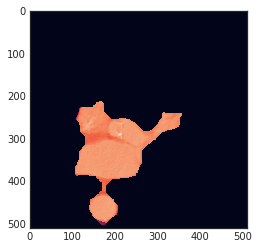

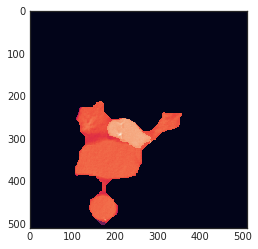

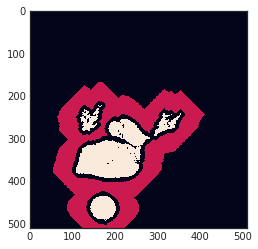

In [28]:
plt.imshow(np.load(os.path.join(PATHS['DATA'], 'watereshed', patient_ids[0], 'patch_130.npy'))[..., 0])
plt.show()
plt.imshow(np.load(os.path.join(PATHS['DATA'], 'watereshed', patient_ids[0], 'patch_130.npy'))[..., 0] + 
           500 * np.load(os.path.join(PATHS['DATA'], 'watereshed', patient_ids[0], 'patch_130.npy'))[..., 1])
plt.show()
plt.imshow(np.load(os.path.join(PATHS['DATA'], 'watereshed', patient_ids[0], 'marker_130.npy')))

In [ ]:
from multiprocessing import Pool
import h5py
import uuid
import pickle


BATCH_SIZE = 10

patient_ids = glob(os.path.join(PATHS['DATA'], '*'))
patient_ids = [os.path.basename(pid) for pid in patient_ids if len(os.path.basename(pid)) == 9]

processeds = list()
for patient_id in tqdm(patient_ids):
    try:
        processeds.append(process(patient_id))
    except:
        print(patient_id)
    pickle.dump(processeds, open(os.path.join(PATHS['DATA'], 'watereshed_processed_meta.pkl'), 'wb'))

HBox(children=(IntProgress(value=0, max=538), HTML(value='')))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


0458R3023
1166R3021
